In [215]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [216]:
## 读取表格并转为numpy
train=pd.read_csv('./train.csv')
train.iloc[:,41:-1]=(train.iloc[:,41:-1]-np.mean(train.iloc[:,41:-1],axis=0))/np.std(train.iloc[:,41:-1],axis=0)
train_data=train.to_numpy()
labels=train_data[:,-1]
## 不要忘记删除id列
features=train_data[:,1:-1]

In [217]:
## 转成tensor
features=torch.Tensor(features)
labels=torch.Tensor(labels)
new_shape = (len(labels), 1)
labels = labels.view(new_shape)

In [218]:
## 分割train valid set
idx=np.arange(0,len(labels),10)
valid_set=features[idx]
valid_label=labels[idx]
idx=[i for i in range(len(labels)) if i%10!=0]
train_set=features[idx]
train_label=labels[idx]

In [219]:
train_set.shape,valid_set.shape

(torch.Size([2430, 93]), torch.Size([270, 93]))

In [ ]:
train_label.shape,valid_label.shape

(torch.Size([2430, 1]), torch.Size([270, 1]))

In [220]:
class CustomImageDataset(Dataset):
    def __init__(self, features, labels, transform=None, target_transform=None):
        self.feature=features
        self.label=labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
      ## 注意此处为了在train和test时都能使用的写法
        if self.label is not None:
          return self.feature[idx],self.label[idx]
        else:
          return self.feature[idx]

In [222]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [223]:
def train(train_dataloader,valid_dataloador, model, loss_fn, optimizer,device):
    train_loss_lst=[]
    valid_loss_lst=[]

    epoch=0
    n_epoch=3000
    min_loss=1000
    early_stop_cnt=0
    early_stop_cnt_max=500

    size = len(train_dataloader.dataset)
    ## 将model调为训练模式
    model.train()

    while epoch<=n_epoch:

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            train_loss_lst.append(loss.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if batch % 10 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # print(f"epoch: {epoch},")
        # print("-------------------------------")
        epoch+=1    
        
        ## 进行模型评估valid
        valid_loss=valid(model,valid_dataloador,device,loss_fn)
        valid_loss_lst.append(valid_loss)
        if valid_loss<min_loss:
            min_loss=valid_loss
            torch.save(model.state_dict(),'./model.pth')  
            print(f'epoch: {epoch}, loss is decreasing , loss is {valid_loss}')

            early_stop_cnt=0
        else:
            early_stop_cnt+=1
            # print(f'loss keep same , loss is {valid_loss}')
            if early_stop_cnt>=early_stop_cnt_max:
                break

    return (train_loss_lst,valid_loss_lst)

In [224]:
def valid(model,valid_dataloador,device,loss_fn):
    ## input: model
    ## return: valid loss
    model.eval()
    total_loss=0
    with torch.no_grad():
        for X, y in valid_dataloador:
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss= loss_fn(pred, y)
            # print(loss.detach().cpu().item())
            total_loss+=loss.detach().cpu().item()*len(y)

    return total_loss/len(valid_dataloador.dataset)


In [225]:
training_data=CustomImageDataset(train_set,train_label)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
valid_data=CustomImageDataset(valid_set,valid_label)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [226]:
##  定义model
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(93, 1),

        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [227]:
loss_fn = nn.MSELoss()
model = NeuralNetwork().to(device)
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=93, out_features=1, bias=True)
  )
)


In [228]:
(train_loss_lst,valid_loss_lst)=train(train_dataloader,valid_dataloader, model, loss_fn, optimizer,device)

epoch: 1, loss is decreasing , loss is 75.67728576660156
epoch: 2, loss is decreasing , loss is 12.688669840494791
epoch: 3, loss is decreasing , loss is 3.8169736756218806
epoch: 4, loss is decreasing , loss is 2.185748377552739
epoch: 5, loss is decreasing , loss is 1.713655412638629
epoch: 6, loss is decreasing , loss is 1.4768345810748913
epoch: 7, loss is decreasing , loss is 1.3271608273188273
epoch: 8, loss is decreasing , loss is 1.2631407194667392
epoch: 9, loss is decreasing , loss is 1.1755021360185411
epoch: 10, loss is decreasing , loss is 1.1318550401263767
epoch: 11, loss is decreasing , loss is 1.1104914170724374
epoch: 12, loss is decreasing , loss is 1.0896550370587244
epoch: 13, loss is decreasing , loss is 1.0641890962918599
epoch: 14, loss is decreasing , loss is 1.0486015734849152
epoch: 15, loss is decreasing , loss is 1.0456212829660487
epoch: 16, loss is decreasing , loss is 1.036535095727002
epoch: 18, loss is decreasing , loss is 1.0272031797303094
epoch: 19,

In [229]:
len(train_loss_lst),len(valid_loss_lst)

(54568, 1436)

## 1
两层

不做normaliztion 最终收敛在58.94

做normaliztion 最终收敛在0.7291709469424353

## 2
一层

不做normaliztion 单层的直接线性根本训练不起来

做normaliztion 单层也可以训练 最终收敛在0.7598297108102727

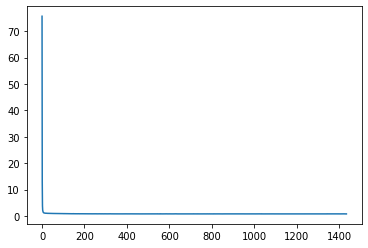

In [230]:
plt.plot(np.arange(len(valid_loss_lst)),valid_loss_lst)
plt.show()

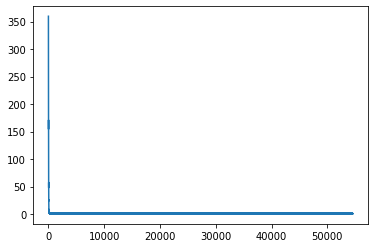

In [231]:
plt.plot(np.arange(len(train_loss_lst)),train_loss_lst)
plt.show()

In [266]:
test=pd.read_csv('./test.csv')
test.iloc[:,41:]=(test.iloc[:,41:]-np.mean(test.iloc[:,41:],axis=0))/np.std(test.iloc[:,41:],axis=0)
test_data=test.to_numpy()
test_features=test_data[:,1:]

## 在转成tensor前转成np.float32  否则后面会出错
test_features=test_features.astype(np.float32)

test_features=torch.tensor(test_features)
print(test_features.shape)
print(test_features.dtype)

torch.Size([893, 93])
torch.float32


In [267]:
test_dataloador=CustomImageDataset(test_features,None)

In [268]:
def test(test_dataloador,model):
  ## return pred on test_set
  model.eval()
  pred_lst=[]
  with torch.no_grad():
    for x in test_dataloador:
      pred=model(x)
      pred_lst.append(pred.detach().item())
  return pred_lst  



In [269]:
final_pred=test(test_dataloador,model)

In [ ]:
final_pred

In [273]:
import csv

In [274]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [275]:
save_pred(final_pred,'starfish.csv')

Saving results to starfish.csv
